[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1eXmkqUaxGTGi4aGgK9eZbYW5dHfUyX4M?usp=sharing)

# Lab 3: Adding Tools for RAG

This notebook builds on Labs 1 and 2 by adding tools and persistent memory to our cake shop assistant,
making it more powerful and useful for business applications.

In [1]:
!pip install -q langgraph langchain_openai langchain_community langgraph_supervisor langgraph-checkpoint-sqlite langchain_experimental \
   pymupdf chromadb grandalf gradio pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 11.4 MB/s eta 0:00

In [2]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2ubuntu2.1 [15.9 kB]
Get:4 http://archive.ubun

In [3]:
from typing import Annotated, List, Dict, Any, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
import pandas as pd
import requests
import os
import sqlite3
from langchain_openai import ChatOpenAI
from langchain.agents import Tool
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_community.document_loaders import CSVLoader, TextLoader
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.runnables import RunnablePassthrough

In [4]:
from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get("TT_OPENAI_KEY")

In [5]:
model_name = "gpt-4o-mini"
llm = ChatOpenAI(model=model_name, temperature=0)

In [6]:
os.makedirs('./data', exist_ok=True)
os.makedirs('./report', exist_ok=True)

In [7]:
import requests

os.makedirs('./data', exist_ok=True)

links = [
    {"url":'https://raw.githubusercontent.com/IvanReznikov/Generative-AI-Creating-a-LLM-Chatbot-for-Business/refs/heads/main/data/accessories.pdf', "name": "accessories"},
    {"url":'https://raw.githubusercontent.com/IvanReznikov/Generative-AI-Creating-a-LLM-Chatbot-for-Business/refs/heads/main/data/cupcakes.pdf', "name": "cupcakes"},
    {"url":'https://raw.githubusercontent.com/IvanReznikov/Generative-AI-Creating-a-LLM-Chatbot-for-Business/refs/heads/main/data/desserts.pdf', "name": "desserts"},
    {"url":'https://raw.githubusercontent.com/IvanReznikov/Generative-AI-Creating-a-LLM-Chatbot-for-Business/refs/heads/main/data/cakes.pdf', "name": "cakes"},
    {"url":'https://raw.githubusercontent.com/IvanReznikov/Generative-AI-Creating-a-LLM-Chatbot-for-Business/refs/heads/main/data/cake_descriptions.csv', "name": "cake_table"}
]

for link in links:

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36',
    }

    response = requests.get(
        link["url"],
        headers=headers,
    )

    if link['name'] == "cake_table":
      _path = f"./data/{link['name']}.csv"
    else:
      _path = f"./data/{link['name']}.pdf"
    with open(_path, "wb") as f:
      f.write(response.content)

In [8]:
pdf_documents = []
for pdf_link in os.listdir("./data"):
    if pdf_link[-3:] == "pdf":
      pdf_loader = PyMuPDFLoader(f"./data/{pdf_link}")
      data = pdf_loader.load()
      pdf_documents += data

In [9]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50, #this is a great parameter to experiment
    separators=["\n\n", "\n", ".", ","] #what other separators can you think off?
)

# Split the documents
chunks = text_splitter.split_documents(pdf_documents)
print(f"Created {len(chunks)} chunks from {len(pdf_documents)} documents")
print(f"Sample chunk: {chunks[0].page_content[:50]}...")

Created 52 chunks from 11 documents
Sample chunk: Cakes descriptions 
==============================...


In [10]:
# Initialize embeddings
embeddings = OpenAIEmbeddings(model = "text-embedding-3-large")

# Create a Chroma vector store
vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 10, })

In [11]:
# Load cake data
cake_data = pd.read_csv("./data/cake_table.csv", encoding='cp1252')

In [12]:
import sqlite3

# Connect to database
conn = sqlite3.connect("price_db.sqlite")
cursor = conn.cursor()

# Create table
cursor.execute("""
CREATE TABLE IF NOT EXISTS items (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT NOT NULL,
    category TEXT CHECK(category IN ('Cake', 'Cupcake', 'Dessert', 'Accessory')),
    price DECIMAL(6, 2) NOT NULL
);
""")

# Items to insert (name, category, price)
items = [
    # --- Cakes ---
    ("Torta della Nonna Amore", "Cake", 34.99),
    ("Festiva della Sicilia", "Cake", 36.99),
    ("Dubai Midnight Pistachio Fantasy", "Cake", 42.50),
    ("Ferrari Redline Fudge", "Cake", 39.00),
    ("Goalpost Delight - Soccer Fan Cake", "Cake", 44.00),
    ("Trophy Cake – Champions Edition", "Cake", 47.50),
    ("Birthday Blast Berry Bomb", "Cake", 33.50),
    ("ChocoCaramel Birthday Surprise", "Cake", 35.75),
    ("Velvet Dream Cloud", "Cake", 38.00),
    ("Hazelnut Toffee Crown", "Cake", 36.75),
    ("Molten Mango Lava Cake", "Cake", 32.00),
    ("Black Forest Cake", "Cake", 29.99),
    ("Tiramisu Cake", "Cake", 34.00),
    ("Red Velvet Cake", "Cake", 31.00),
    ("Carrot Cake", "Cake", 30.00),
    ("Opera Cake", "Cake", 37.00),
    ("Sacher Torte", "Cake", 38.50),
    ("Strawberry Shortcake", "Cake", 33.00),
    ("Lemon Drizzle Cake", "Cake", 28.00),
    ("Cheesecake", "Cake", 30.00),
    ("Rainbow Cake", "Cake", 35.00),
    ("Chocolate Truffle Cake", "Cake", 36.00),

    # --- Cupcakes ---
    ("Midnight Mocha Cupcake", "Cupcake", 4.50),
    ("Lavender Honey Blossom Cupcake", "Cupcake", 4.75),
    ("Strawberry Cloud Cupcake", "Cupcake", 4.25),
    ("Salted Caramel Pretzel Crunch Cupcake", "Cupcake", 4.60),
    ("Choco-Mint Frostbite Cupcake", "Cupcake", 4.40),
    ("Blueberry Pancake Breakfast Cupcake", "Cupcake", 4.80),
    ("Pistachio Rosewater Cupcake", "Cupcake", 5.00),
    ("Campfire S'mores Cupcake", "Cupcake", 4.70),
    ("Rainbow Confetti Birthday Cupcake", "Cupcake", 4.50),
    ("Cherry Cola Retro Cupcake", "Cupcake", 4.30),

    # --- Desserts ---
    ("Vanilla Bean Panna Cotta with Berry Compote", "Dessert", 6.00),
    ("Chocolate Lava Dome", "Dessert", 6.50),
    ("Passionfruit Tartlets", "Dessert", 5.50),
    ("Raspberry Almond Financiers", "Dessert", 4.50),
    ("Matcha White Chocolate Blondies", "Dessert", 4.75),
    ("Mini Fruit Pavlovas", "Dessert", 5.25),
    ("Banana Split Jars", "Dessert", 5.75),
    ("Tiramisu Shots", "Dessert", 3.50),
    ("Earl Grey Shortbread Cookies", "Dessert", 4.00),
    ("Caramel Popcorn Brittle", "Dessert", 3.75),

    # --- Accessories ---
    ("Edible Flower Sets", "Accessory", 6.99),
    ("Mini Sparkler Candles", "Accessory", 3.50),
    ("Handwritten Message Tags", "Accessory", 2.00),
    ("Reusable Dessert Dome Cases", "Accessory", 7.00),
    ("Themed Cupcake Toppers", "Accessory", 4.00),
    ("Sprinkle Lab Mini Kits", "Accessory", 5.25),
    ("Dessert Scented Candles", "Accessory", 8.00),
    ("Cake Slicer Gift Set", "Accessory", 12.00),
    ("Tiny Message Bottles", "Accessory", 2.50),
    ("Hot Chocolate Bombs", "Accessory", 4.25)
]

# Insert into table
cursor.executemany("INSERT INTO items (name, category, price) VALUES (?, ?, ?);", items)

conn.commit()
conn.close()


## Step 1: Define the Tools for our Cake Assistant

We'll create several tools that will enhance our assistant's capabilities:
1. A search tool to find cakes by type, flavor, or occasion
2. A notification tool to alert staff about orders or inquiries
3. A price calculator tool for estimating cake costs

In [13]:
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.tools import BaseTool, tool, StructuredTool, Tool
from langchain_experimental.utilities import PythonREPL
from langchain_experimental.agents import create_pandas_dataframe_agent
from pydantic import BaseModel, Field
import pandas as pd

In [14]:
# Define RAG search tool
@tool
def search_cake_descriptions(query: str) -> str:
    """Search for information about cakes, desserts and accessories descriptions"""
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

# Define CSV query tool
class CSVQueryInput(BaseModel):
    """Input for CSV query tool."""
    query: str = Field(description="The query or question about the CSV data")

class CSVAgentTool(BaseTool):
    """Tool for analyzing CSV data"""
    name: str = "csv_data_analyzer"
    description: str = """Analyze CSV data by asking questions in natural language. This tool can access information about:
        ingredients, short description, energy_kcal, weight_grams, restrictions, delivery_time_hr, availability"""
    args_schema: type[BaseModel] = CSVQueryInput
    return_direct: bool = True

    def _run(self, query: str) -> str:
        """Run the tool."""
        try:
            # Load the CSV into a pandas DataFrame
            df = pd.read_csv("./data/cake_table.csv", encoding='cp1252')

            # Create a Pandas DataFrame agent
            agent = create_pandas_dataframe_agent(
                ChatOpenAI(temperature=0, model=model_name),
                df,
                verbose=True,
                agent_type="openai-functions",
                allow_dangerous_code=True
            )

            # Run the agent on the query
            result = agent.run(query)
            return result

        except Exception as e:
            return f"Error processing CSV query: {str(e)}"

    async def _arun(self, query: str) -> str:
        """Run the tool asynchronously."""
        return self._run(query)

# Instantiate the CSV tool
csv_tool = CSVAgentTool()

In [15]:
# Create a Python REPL tool
python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description="Execute Python code to analyze data. Input should be valid Python code.",
    func=python_repl.run
)

In [16]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///price_db.sqlite")

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [17]:
from langgraph.prebuilt import create_react_agent

system_prompt = """
Use the database to find out prices for all the items.

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect=db.dialect,
    top_k=5,
)

sql_agent = create_react_agent(
    llm,
    tools,
    prompt=system_prompt,
    name="sql_agent"
)

In [18]:
query = "What are the prices for the Festiva della Sicilia and Velvet Dream Cloud?"
response = sql_agent.invoke({"messages": [{"role": "user", "content": query}]})

In [19]:
print(response['messages'][-1].content)

The prices for the items are as follows:

- **Festiva della Sicilia**: $36.99
- **Velvet Dream Cloud**: $38.00


In [20]:
from typing import Annotated, Dict, List, Literal, TypedDict, Union
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import Command, Send
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model
from langgraph.pregel import Pregel
from IPython.display import display, Image
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command

In [21]:
class State(MessagesState):
    next: str


def make_supervisor_node(llm, members: list[str], prompt: str = "") -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH." + prompt
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

In [22]:
## 1. Create worker agents

from typing import Literal, TypedDict, Annotated, List
from langchain_core.messages import HumanMessage, AnyMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import Command, Send
from langgraph.graph.message import add_messages

# Create RAG agent
rag_agent = create_react_agent(
    llm,
    tools=[search_cake_descriptions, csv_tool, repl_tool],
    prompt=(
        "You are a RAG agent specializing in retrieval and information synthesis.\n\n"
        "INSTRUCTIONS:\n"
        "- Retrieve information from documents and provide comprehensive answers\n"
        "- If a question involves pricing data, delegate to the SQL agent\n"
        "- Use your tools to find relevant information and provide context\n"
        "- Be thorough and accurate in your responses\n"
        "- Think step by step"
    ),
)

# Create Visualization agent
viz_agent = create_react_agent(
    llm,
    tools=[repl_tool],
    prompt=(
        "You are a visualization agent specializing in data presentation.\n\n"
        "INSTRUCTIONS:\n"
        "- Create clear and informative visualizations of data\n"
        "- Use appropriate chart types for different data relationships\n"
        "- Ensure visualizations are properly labeled and easy to understand\n"
        "- Provide brief explanations of what the visualizations show\n"
        "- Think step by step"
    ),
)

In [23]:
def rag_node(state) -> Command[Literal["supervisor"]]:
    result = rag_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="rag_node")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

def viz_node(state) -> Command[Literal["supervisor"]]:
    result = viz_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="viz_node")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

def sql_node(state) -> Command[Literal["supervisor"]]:
    result = sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="sql_node")
            ]
        },
        goto="supervisor",
    )


In [24]:
supervisor_prompt = """
Use several nodes in a chain order if required.
If you need data regarding prices - use sql_node
If you need data regarding descriptions, ingredients and desserts specs - use rag_node

For example if the user asks regarding the price of birthday accessories - first check rag_node what that might be
and check the list of the prices in sql_node.
If the user asks to draw a histogram of cake prices extract the cake prices first from sql_node and run the viz_node using this data.
If the user asks to draw a bar chart of cake ingredients extract the cake table first from rag_node and run the viz_node using this data.
"""
supervisor_node = make_supervisor_node(llm, ["viz_node", "rag_node", "sql_node"], supervisor_prompt)

In [25]:
from langgraph.graph import StateGraph, START, END

graph = (
    StateGraph(State)
    .add_node("supervisor", supervisor_node)
    .add_node("rag_node", rag_node)
    .add_node("viz_node", viz_node)
    .add_node("sql_node", sql_node)
    .add_edge(START, "supervisor")
    .add_edge("supervisor", END)
    .compile()
)



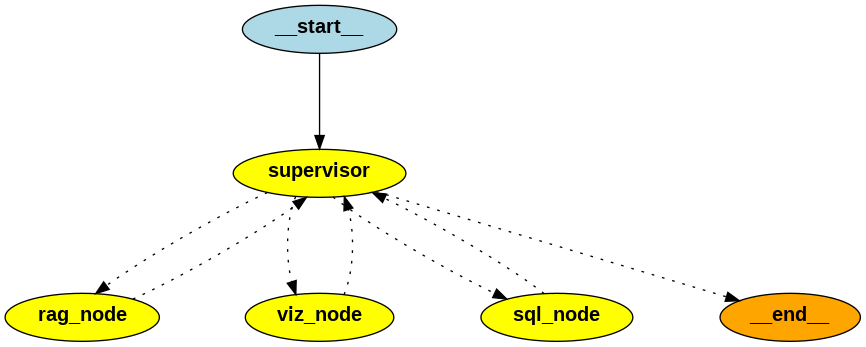

In [26]:
from IPython.display import Image, display

#display(Image(rag_viz_graph.get_graph().draw_mermaid_png()))
#display(Image(rag_viz_graph.get_graph().print_ascii()))
display(Image(graph.get_graph().draw_png()))

In [27]:
query = "What are the prices for the Festiva della Sicilia and the Velvet Dream Cloud?"

for s in graph.stream(
    {"messages": [("user", query)]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'rag_node'}}
---


<ipython-input-14-98136846df0c>:37: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = agent.run(query)




> Entering new AgentExecutor chain...

> Entering new AgentExecutor chain...


Invoking: `python_repl_ast` with `{'query': "df[df['Name'] == 'Velvet Dream Cloud']"}`


                 Name Category  \
8  Velvet Dream Cloud        G   

                                         Ingredients  \
8  Vanilla sponge, mascarpone, white chocolate mo...   

                                         Description  Energy_kcal  \
8  Fluffy, cloud-like cake with light, elegant cr...          350   

   Weight_grams           Restrictions  Delivery_time_hr Available  
8          1000  Contains dairy, wheat                24       Yes  The dataframe `df` does not contain a column for price. To find the price of "Festiva della Sicilia," you would need to check another source or dataset that includes pricing information.

> Finished chain.
The price of the "Velvet Dream Cloud" is not provided in the dataframe. The available information includes its ingredients, description, energy content, weight, restr

In [28]:
query = "What are the prices forall the cakes containing nuts"

for s in graph.stream(
    {"messages": [("user", query)]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'rag_node'}}
---


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "# First, we need to filter the dataframe for cakes that contain nuts in their ingredients\nnut_cakes = df[df['Ingredients'].str.contains('nuts', case=False)]\n\n# Now, we will extract the relevant columns, including the Name and Price (assuming there's a Price column)\n# However, since the provided dataframe does not include a Price column, I will just display the names of the cakes containing nuts.\nnut_cakes[['Name', 'Category', 'Ingredients']]"}`


                       Name Category  \
0   Torta della Nonna Amore        G   
9     Hazelnut Toffee Crown        G   
14              Carrot Cake        R   

                                          Ingredients  
0   Ricotta, pine nuts, lemon zest, vanilla, sugar...  
9     Hazelnuts, caramel, praline, brown sugar sponge  
14             Carrots, walnuts, spices, cream cheese  The cakes containing nuts in thei

{'supervisor': {'next': 'rag_node'}}
---


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nfrom collections import Counter\n\n# Assuming df is already defined as the dataframe\n# Split the ingredients by comma and count the frequency\ningredients_series = df['Ingredients'].str.split(', ').explode()\ningredients_count = Counter(ingredients_series)\n\n# Convert to a DataFrame for better readability\ningredients_frequency = pd.DataFrame(ingredients_count.items(), columns=['Ingredient', 'Frequency'])\n\n# Sort by frequency\ningredients_frequency = ingredients_frequency.sort_values(by='Frequency', ascending=False)\n\ningredients_frequency"}`


         Ingredient  Frequency
23    whipped cream          3
31        Chocolate          3
29     cream cheese          3
8        mascarpone          3
28   vanilla sponge          3
..              ...        ...
63    biscuit crust          1
64  seasonal fruits          1
65    Food colori

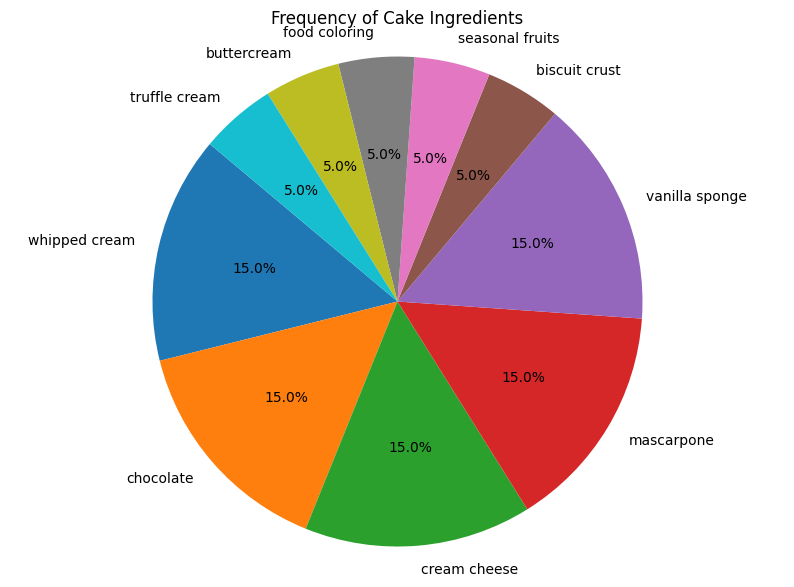

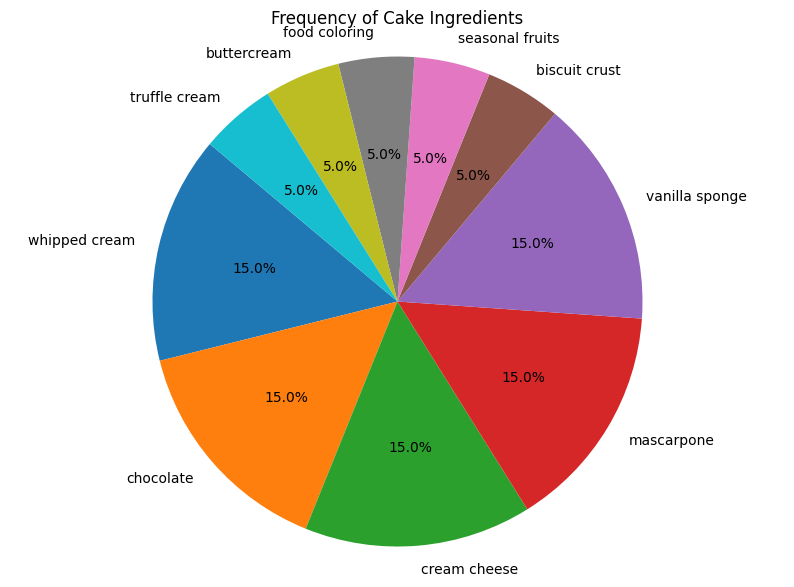

{'viz_node': {'messages': [HumanMessage(content='The pie chart visualizes the frequency of various cake ingredients. Each slice of the pie represents the proportion of each ingredient used in the cakes, with the percentage displayed on the chart.\n\n### Explanation of the Chart:\n- **Ingredients with Higher Frequency**: Ingredients like whipped cream, chocolate, cream cheese, mascarpone, and vanilla sponge each have a frequency of 3, indicating they are commonly used in cake recipes.\n- **Ingredients with Lower Frequency**: Ingredients such as biscuit crust, seasonal fruits, food coloring, buttercream, and truffle cream have a frequency of 1, showing they are less frequently used.\n\nThis visualization helps to quickly identify which ingredients are more prevalent in cake recipes. If you need further analysis or a different type of visualization, let me know!', additional_kwargs={}, response_metadata={}, name='viz_node', id='8b9d1025-664a-4f90-af2b-b2eeeda252b2')]}}
---
{'supervisor': 

In [30]:
query = "draw a pie chart of cakes ingredients frequency"

for s in graph.stream(
    {"messages": [("user", query)]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")